In [2]:
%matplotlib inline

# It is best to start with USE_GPU = False (implying CPU). Switch USE_GPU to True only if you want to use GPU. However... 
# we strongly recommend to wait until you are absolutely sure your CPU-based code works (at least on single image dataset)
USE_GPU = True

# Python Libraries
import random
import math
import numbers
import platform
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

In [3]:
import skimage
from skimage.transform import SimilarityTransform


def get_corners(im):
    """returns cartesian coordinates of the corners 
        of an (h,w,c) image centered at (0,0)"""
    h,w,c = im.shape
#     h -= 1
#     w -= 1
    corners = np.array([[-h/2, w/2],[h/2, w/2],[h/2, -w/2],[-h/2, -w/2]])
    return corners
    

def get_warped_corners(corners, projection):
    """ Warps the corners according to the given projection"""
    warpedCorners = projection(corners)
    minC = np.floor(np.min(warpedCorners,axis=0))
    maxC = np.ceil(np.max(warpedCorners,axis=0))
#     newCenter = ((maxC-minC)+1)/2 - 1
    
    return {'min':minC, 'max':maxC, 'warpedcorners':warpedCorners,'corners':corners}

def get_warped_corners_image(im, projection):
    """ return the corners of a transformed image"""
    corners = get_corners(im)
    return get_warped_corners(corners, projection)
    
def square_in_sqare(outCorners, inCorners):
    """Checks whether a transformed square contains another square 
     square 0:TL,1:BR,2:TR,3BR
     
     tests
         testfalse = square_in_sqare(outCorners=np.array([[23.765, 66.235],[66.235, 66.235],[66.235, 23.765],[23.765, 23.765]]), 
                                           inCorners=np.array([[-15.5,  15.5],[ 15.5,  15.5],[ 15.5, -15.5],[-15.5, -15.5]]))
        assert testfalse == False
        print('Test passed with return value',testfalse)


        testfalse = square_in_sqare(outCorners=np.array([[-2.,  2.],[ 2.,  2.],[ 2., -2.],[-2., -2.]]), 
                                           inCorners=np.array([[3.,  2.],[ 7.,  2.],[ 7., -2.],[3., -2.]]))
        assert testfalse == False
        print('Test passed with return value',testfalse)


        testfalse = square_in_sqare(outCorners=np.array([[-1.,  1.],[ 1.,  1.],[ 1., -1.],[-1., -1.]]), 
                                           inCorners=np.array([[-2.,  2.],[ 2.,  2.],[ 2., -2.],[-2., -2.]]))
        assert testfalse == False
        print('Test passed with return value',testfalse)

        testTrue = square_in_sqare(outCorners=np.array([[-3.,  3.],[ 3.,  3.],[ 3., -3.],[-3., -3.]]), 
                                   inCorners=np.array([[-2.,  2.],[ 2.,  2.],[ 2., -2.],[-2., -2.]]))
        assert testTrue == True
        print('Test passed with return value',testTrue)

        testTrue = square_in_sqare(outCorners=np.array([[-2.,  2.],[ 2.,  2.],[ 2., -2.],[-2., -2.]]), 
                           inCorners=np.array([[-1.,  1.],[ 1.,  1.],[ 1., -1.],[-1., -1.]]))
        assert testTrue == True
        print('Test passed with return value',testTrue)

        testTrue = square_in_sqare(outCorners=np.array([[-4.5691323,  3.3351207],[3.3351207,  4.5691323],
                                                       [4.5691323, -3.3351207],[-3.3351207, -4.5691323]]), 
                           inCorners=np.array([[-2., -2.],[ 2., -2.],[-2.,  2.],[ 2.,  2.]]))
        assert testTrue == True
        print('Test passed with return value',testTrue)

        testTrue = square_in_sqare(outCorners=np.array([[-2.,  2.],[ 2.,  2.],[ 2., -2.],[-2., -2.]]), 
                           inCorners=np.array([[-2.,  2.],[ 2.,  2.],[ 2., -2.],[-2., -2.]]))
        assert testTrue == True
        print('Test passed with return value',testTrue)
     """
    def getPoint(a,b,x=None,xfunc=False):
        if xfunc:
            def solve(point,coord='x'):
                return (x,point[1])
                
        else:
            def solve(point,coord='x'):
                if coord == 'x': 
                    y = point[1]
                    return ((y-b)/a,y)
                elif coord == 'y':
                    x = point[0]
                    return (x,a*x+b)
                else:
                    raise NotImplementedError
        return solve
            
    points = ['TL','TR','BR','BL']
    pd = {v:i for i,v in enumerate(points)}
    lines = []
    
    side_list = []
    for i in range(4):
        
        flags_geq = []
        flags_leq = []
        if outCorners[i,0] == outCorners[(i+1) % 4,0]:
            lines.append(getPoint(None,None,outCorners[i,0],xfunc=True))
            #check if the line is vertical
            for ii in range(4):
                isleq = inCorners[ii,0] <= outCorners[i,0]
                isgeq = inCorners[ii,0] >= outCorners[i,0]
                flags_leq.append(isleq)
                flags_geq.append(isgeq)
        else:
            if outCorners[i,0] < outCorners[(i+1) % 4,0]:
                #ensure correct ordering of the points
                x1,y1 = outCorners[i,0],outCorners[i,1]
                x2,y2 = outCorners[(i+1) % 4,0],outCorners[(i+1) % 4,1]
            else:
                x2,y2 = outCorners[i,0],outCorners[i,1]
                x1,y1 = outCorners[(i+1) % 4,0],outCorners[(i+1) % 4,1]

            a = (y2-y1)/(x2-x1)
            b = y1 - (a * x1)
            lines.append(getPoint(a,b))
            for ii in range(4):
                isleq = inCorners[ii,1] <= ( inCorners[ii,0] * a + b )
                isgeq = inCorners[ii,1] >= ( inCorners[ii,0] * a + b )
                flags_leq.append(isleq)
                flags_geq.append(isgeq)
            
        flag_geq = np.sum(flags_geq) == 4
        flag_leq = np.sum(flags_leq) == 4
        if (not flag_geq) and (not flag_leq):
            return False
        elif flag_geq:
            side_list.append('geq')
        elif flag_leq:
            side_list.append('leq')
            
    #check for correct summetry
    if side_list[0] == side_list[2] or side_list[1] == side_list[3]:
        return False
    
    
    for i1,i2 in [(0,2),(1,3)]:
        if side_list[i1] == 'geq' and side_list[i2] == 'leq':
            flags_x = []
            flags_y = []
            for i in range(4):
                pt = (inCorners[i,0],inCorners[i,1])
                pt1x = lines[i1](point=inCorners[i,:],coord='x')
                pt2x = lines[i2](point=inCorners[i,:],coord='x')
                flags_x.append(pt1x <= pt and pt <= pt2x)
                pt1y = lines[i1](point=inCorners[i,:],coord='y')
                pt2y = lines[i2](point=inCorners[i,:],coord='y')
                flags_y.append(pt1y <= pt and pt <= pt2y)
                
                
            flag_x = np.sum(flags_x) == 4
            flag_y = np.sum(flags_y) == 4
            if (not flag_x) and (not flag_y):
                return False
            
        elif side_list[i1] == 'leq' and side_list[i2] == 'geq':
            flags_x = []
            flags_y = []
            for i in range(4):
                pt = (inCorners[i,0],inCorners[i,1])
                pt1x = lines[i1](point=inCorners[i,:],coord='x')
                pt2x = lines[i2](point=inCorners[i,:],coord='x')
                flags_x.append(pt1x >= pt and pt >= pt2x)
                pt1y = lines[i1](point=inCorners[i,:],coord='y')
                pt2y = lines[i2](point=inCorners[i,:],coord='y')
                flags_y.append(pt1y >= pt and pt >= pt2y)
                
            flag_x = np.sum(flags_x) == 4
            flag_y = np.sum(flags_y) == 4
            if (not flag_x) and (not flag_y):
                return False
    
    return True



def get_valid_affine_range_image(im,scale,max_=30,affine_type='translation',threshold=0.1):
    """Given an image and scale multiplier, this function  scales the image and 
    determines the maximal possible affine transformation (currently supporting 
    rotations and translations) which may be performed without causing the resulting 
    image to have empty pixels
    
    params:
        im (np.array) : input image
        scale (float) : the amount by which to scale the image
        max_ (float) : maximal intensity of the affine transformation
        orig_corners (np.array) : list of four corners of the original image
        affine_type (string) : the type of affine translation of interest
        threshold (float) : precision of the estimate
    """
    scaled = get_warped_corners_image(im, SimilarityTransform(scale=scale))
    return get_valid_affine_range(warped_corners=scaled['warpedcorners'],orig_corners=scaled['corners'],
                                  max_=max_, affine_type=affine_type,threshold=threshold)

    
    
def get_valid_affine_range(warped_corners,orig_corners,max_,
                           affine_type='translation',threshold=0.1):
    """Given the corners of a scaled image, this function determines the maximal possible
    affine transformation (currently supporting rotations and translations)
    which may be performed without causing the resulting image to have empty
    pixels
    
    params:
        warped_corners (np.array) : list of four corners of the warped image
        orig_corners (np.array) : list of four corners of the original image
        max_ (float) : maximal intensity of the affine transformation
        affine_type (string) : the type of affine translation of interest
        threshold (float) : precision of the estimate
    """
    def get_trnsf(value,affine_type):
        if affine_type == 'translation':
            return SimilarityTransform(translation=cur_)
        elif affine_type == 'rotation':
            return SimilarityTransform(rotation=np.radians(cur_))
        else:
            raise NotImplementedError
            
    if affine_type == 'rotation':
        max_ = np.min([45,max_])            
    cur_ = max_
    max_valid = 0
    diff = max_ - max_valid
    count = 0
    while(diff > threshold):
        transformed = get_warped_corners(warped_corners, 
                                        get_trnsf(value=cur_,affine_type=affine_type))
        if square_in_sqare(transformed['warpedcorners'], orig_corners):
            max_valid = cur_
        else:
            max_ = cur_
        
        diff = (max_ - max_valid)
        cur_ = max_valid + diff/2
        count +=1
#         print(diff,max_,max_valid)
    return max_valid#,transformed['warpedcorners'],orig_corners
    
im = np.random.randn(32,32,3)
print(im.shape)
scale=1.3
scaled = get_warped_corners_image(im, SimilarityTransform(scale=scale))

valid_r = get_valid_affine_range(
    warped_corners=scaled['warpedcorners'],orig_corners=scaled['corners'],
    max_=15., affine_type='rotation',threshold=0.1
)



(32, 32, 3)


In [64]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

def showPoly(inCorners,outCorners,title='',lim=20):
    polygon1 = Polygon(outCorners,color=[0, 1, 0])
    polygon2 = Polygon(inCorners,color=[1, 0, 0])
    fig, ax = plt.subplots(1,1,figsize=(10,10))

    ax.add_patch(polygon1)
    ax.add_patch(polygon2)
    ax.set_title(title)
    plt.ylim(-lim,100)
    plt.xlim(-lim,lim)
    
def get_viz_from_scale(scale,max_r):
    scaled = get_warped_corners_image(im, SimilarityTransform(scale=scale))
    for x in range(30):
        x = x * np.pi/180
        transformed = get_warped_corners(scaled['warpedcorners'], SimilarityTransform(rotation=x))
        valid = square_in_sqare(transformed['warpedcorners'], scaled['corners'])
        showPoly(inCorners=scaled['corners'],outCorners=transformed['warpedcorners'],
                title="rotation:{}".format(x))

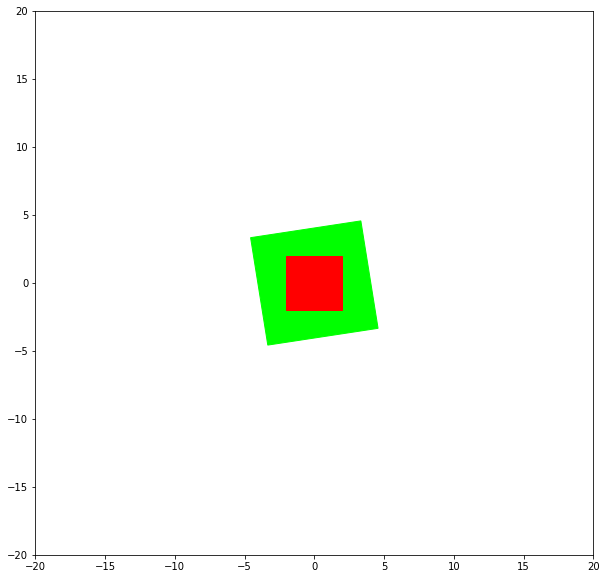

In [65]:
showPoly(outCorners=np.array([[-4.5691323,  3.3351207],[3.3351207,  4.5691323],
                                                       [4.5691323, -3.3351207],[-3.3351207, -4.5691323]]), 
                           inCorners=np.array([[ 2., -2.],[ 2.,  2.],[-2.,  2.],[-2., -2.]]))
    
#     outCorners=np.array([[23.765, 66.235],[66.235, 66.235],[66.235, 23.765],[23.765, 23.765]]), 
#          inCorners=np.array([[-15.5,  15.5],[ 15.5,  15.5],[ 15.5, -15.5],[-15.5, -15.5]]))
 
is_in = square_in_sqare(
    outCorners=np.array([[23.765, 66.235],[66.235, 66.235],[66.235, 23.765],[23.765, 23.765]]), 
    inCorners=np.array([[-15.5,  15.5],[ 15.5,  15.5],[ 15.5, -15.5],[-15.5, -15.5]])
)

assert is_in == False

In [60]:
scale = 1.2248
scaled = get_warped_corners_image(im, SimilarityTransform(scale=scale))

valid_r = get_valid_affine_range(
    warped_corners=scaled['warpedcorners'],orig_corners=scaled['corners'],
    max_=45, affine_type='rotation',threshold=0.001
)
print(valid_r)

15.003890991210938


In [61]:
import os
DATAROOT = os.environ['DATASET_ROOT']


transform_train = transforms.Compose([transforms.ToTensor()])
transform_train_aug = transforms.Compose([SSTransformation(max_r=45., max_t=30, max_s=1.5, shape=(3,32,32)),
                                          transforms.ToTensor()])


batch_size = 4

trainset = torchvision.datasets.CIFAR10(root=DATAROOT, train=True,
                                        download=True, transform=transform_train)


trainset_aug = torchvision.datasets.CIFAR10(root=DATAROOT, train=True,
                                        download=True, transform=transform_train_aug)


# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=DATAROOT, train=False,
                                       download=True, transform=transform_train)

testset_aug = torchvision.datasets.CIFAR10(root=DATAROOT, train=False,
                                       download=True, transform=transform_train_aug)

# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [62]:
def save_im_and_label(filepath,dataset):
    """saves images and their labels from a pytorch dataset
    to a stacked numpy format 
    
    args:
        filepath (str) : the path, relative of absolute, to
            the destianation folder SHOULD INCLUDE FILE PREFIX
        dataset (torchvision.datasets) : the dataset to be saved
    """
    ims_X,ims_Y = [],[]
    for x,y in testset:
        ims_X.append(x.permute(1,2,0))
        ims_Y.append(torch.tensor(y,dtype=torch.long))
        
    np.save('{}_X.npy'.format(filepath),torch.stack(ims_X).numpy())
    np.save('{}_Y.npy'.format(filepath),torch.stack(ims_Y).numpy())
    
# save_im_and_label(filepath='../numpy_datasets/cifar10_saved',dataset=testset)
save_im_and_label(filepath='../numpy_datasets/cifar10_augmented',dataset=testset_aug)

/tmp/ipykernel_14110/23317042.py:81: RuntimeWarning: divide by zero encountered in double_scalars
  return ((y-b)/a,y)


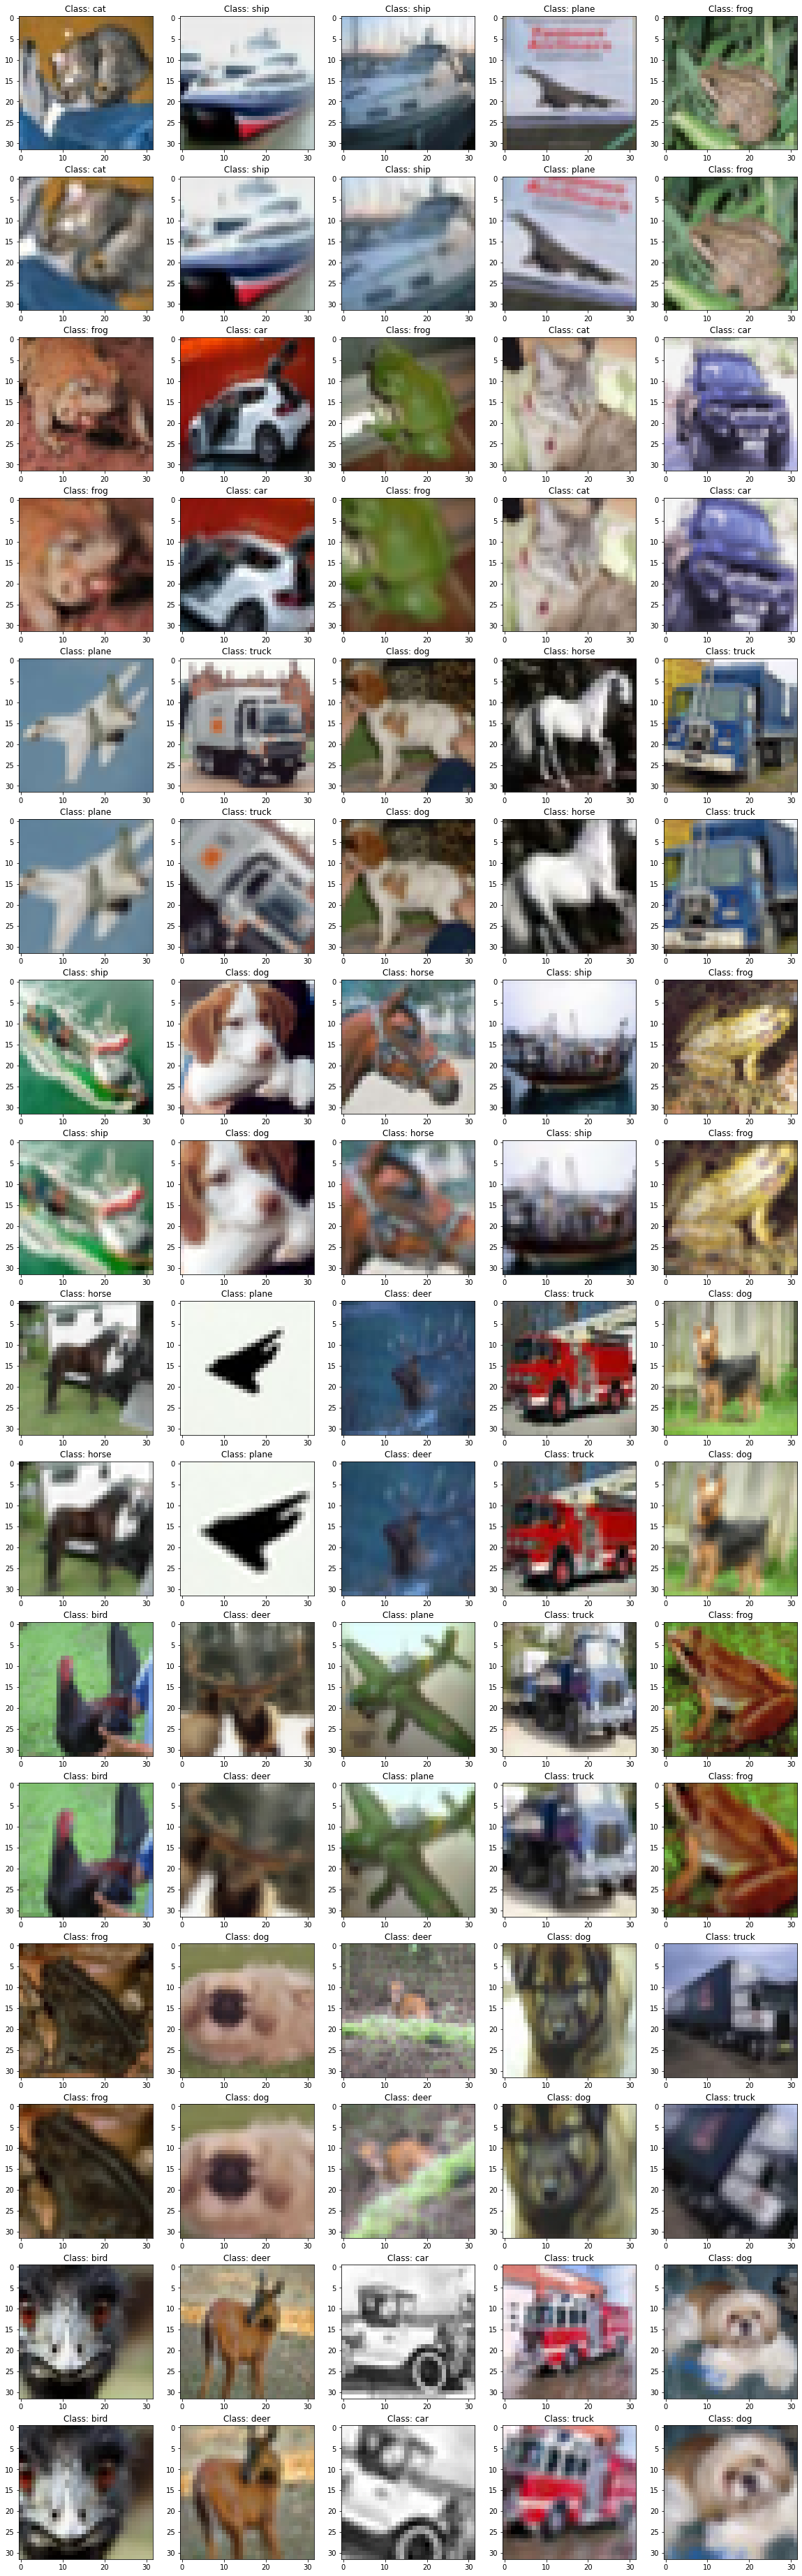

In [63]:
total_plots = 40
plots_per_row = 5
n = np.ceil(total_plots/plots_per_row).astype(np.int32) * 2
fig, axs = plt.subplots(n, plots_per_row, figsize=(20,67))
for x in range(total_plots):
    c,r = x % plots_per_row, int(x/plots_per_row) * 2
    axs[r,c].set_title("Class: {}".format(classes[testset[x][1]]))
    axs[r,c].imshow(testset[x][0].permute(1,2,0))
    
    r += 1
    axs[r,c].set_title("Class: {}".format(classes[testset_aug[x][1]]))
    axs[r,c].imshow(testset_aug[x][0].permute(1,2,0))


fig.show()

# The following cell vizualizes the cifar dataset with and without augmentations. Even rows are augmented, while odd rows are clean

/tmp/ipykernel_3361360/23317042.py:81: RuntimeWarning: divide by zero encountered in double_scalars
  return ((y-b)/a,y)


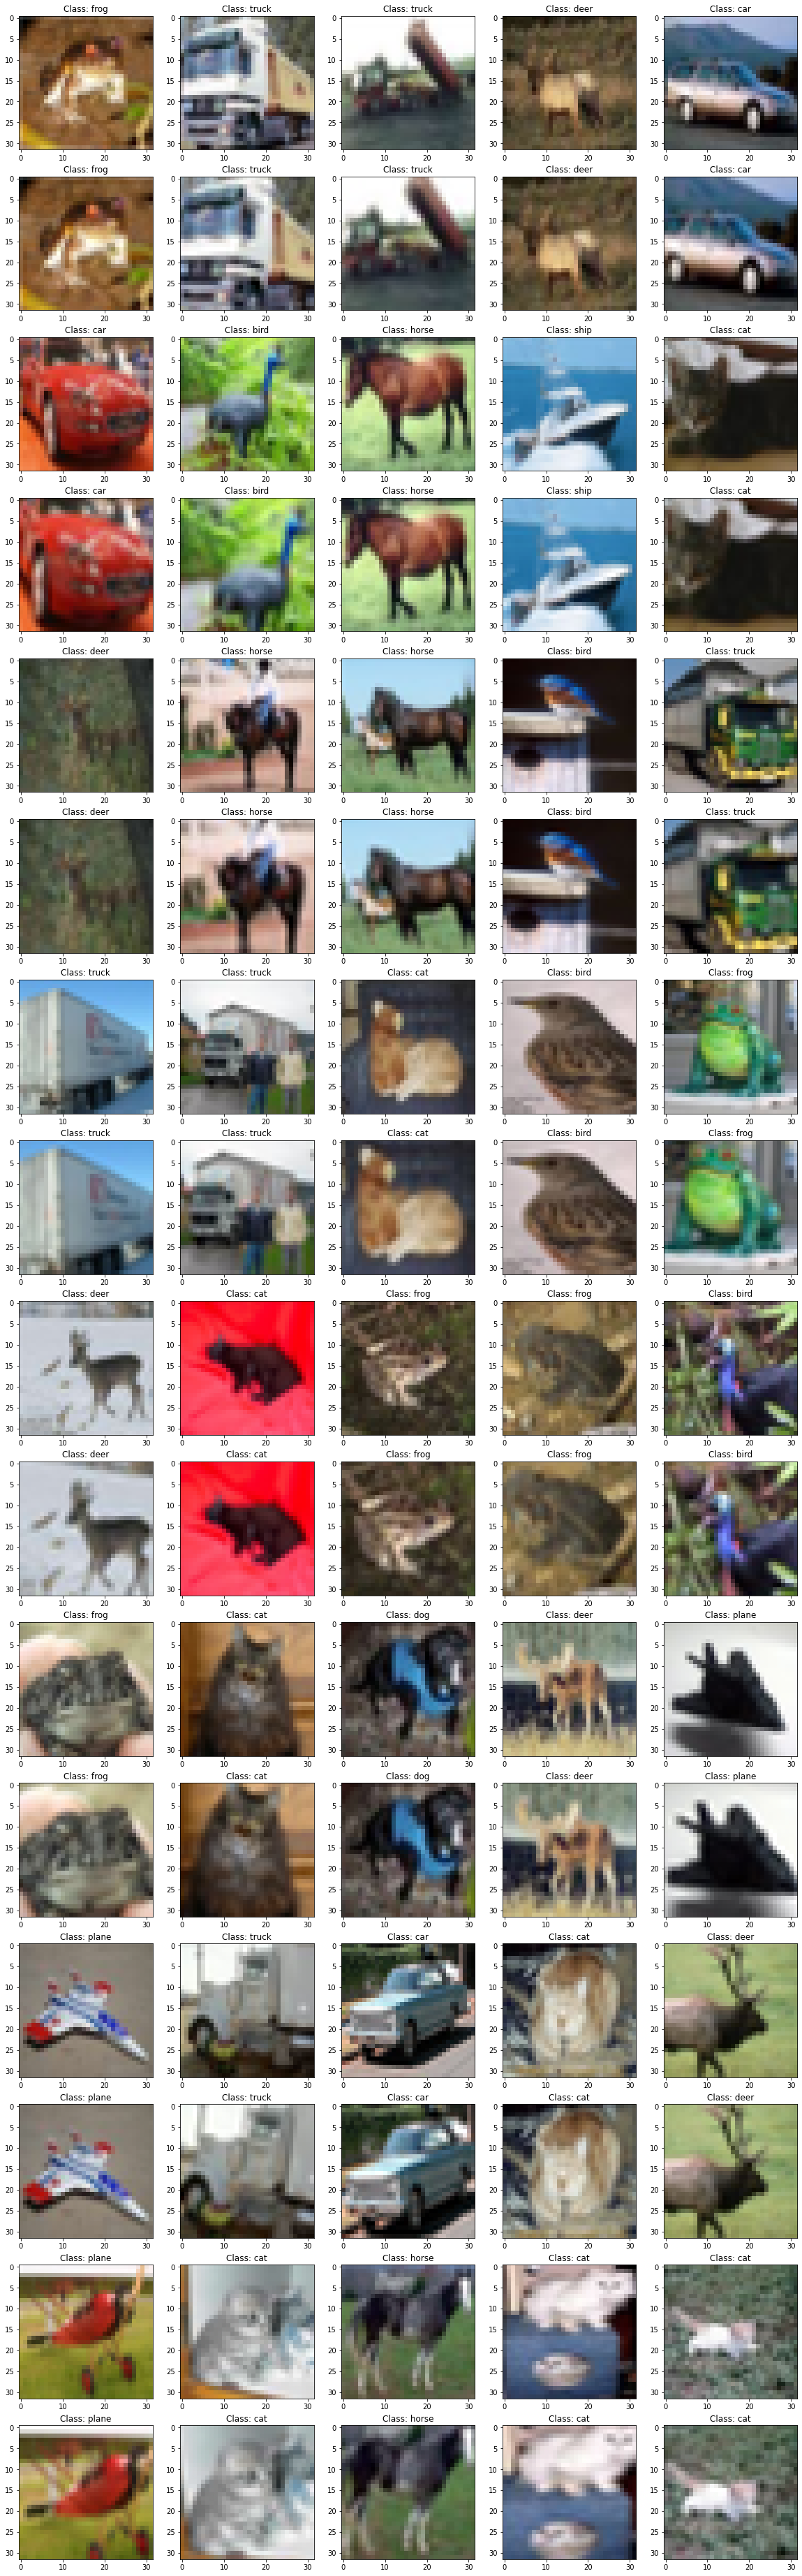

In [60]:
total_plots = 40
plots_per_row = 5
n = np.ceil(total_plots/plots_per_row).astype(np.int32) * 2
fig, axs = plt.subplots(n, plots_per_row, figsize=(20,67))
for x in range(total_plots):
    c,r = x % plots_per_row, int(x/plots_per_row) * 2
    axs[r,c].set_title("Class: {}".format(classes[trainset[x][1]]))
    axs[r,c].imshow(trainset[x][0].permute(1,2,0))
    
    r += 1
    axs[r,c].set_title("Class: {}".format(classes[trainset[x][1]]))
    axs[r,c].imshow(trainset_aug[x][0].permute(1,2,0))


fig.show()

# Dataset viz without augmentations

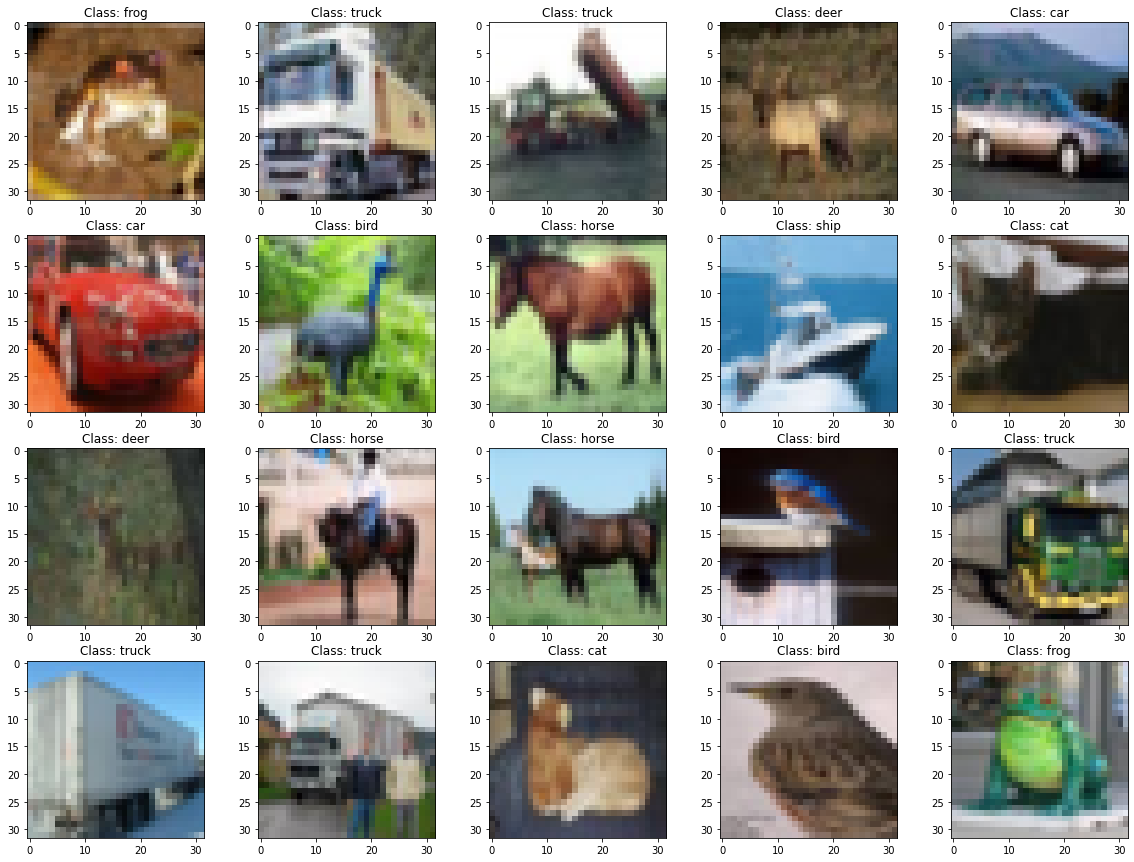

In [17]:
total_plots = 20
plots_per_row = 5
n = np.ceil(total_plots/plots_per_row).astype(np.int32)
fig, axs = plt.subplots(n, plots_per_row, figsize=(20,15))
for x in range(total_plots):
    c,r = x % plots_per_row, int(x/plots_per_row)
    axs[r,c].set_title("Class: {}".format(classes[trainset[x][1]]))
    axs[r,c].imshow(trainset[x][0].permute(1,2,0))


fig.show()